<a href="https://colab.research.google.com/github/rhapsodic-legacy/streamflow_prediction/blob/main/streamflow_time_series_175.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multivariate Time Series Flood Prediction
##### Ten Day Forecast, Top 10 Watersheds (rated by discharge value availability in the last 20 years of that watershed's recordings). 

### Phase One: Isolating the correct data to build a model upon. 
##### Each watershed has differing characteristics, so any given model prediction will be for a certain watershed. The target variable that directly correlates to a flood, is 'discharge'. 
##### Some watersheds have most of their discharge values available for model training, most have many missing values, and some are missing more than 90% of their discharge values. This is due to varying factors. 
#### For Watershed 175, this model's sMAPE score is: 16.545325084985755

In [2]:
# Import Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
# Import relevant libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math, time
import sklearn as sk

In [4]:
# Copy the relevant .csv file to local drive. 
# This is a heavily edited version of the original .csv file.
!cp /content/drive/MyDrive/EDAs/HYSETS_important.csv /content/

In [5]:
# Most of the 40+ columns of the original dataset contain values uniform across a given watershed. 
# They only change between watersheds. 
# It has been my findings thus far, that accurate models can be created without these columns. 
df = pd.read_csv('HYSETS_important.csv')
df.head()

,time,watershed,pr,tasmax,tasmin,discharge
0,1950-01-01,0,6.4,-27.2,-38.9,NaN
1,1950-01-02,0,1.3,-27.8,-39.4,NaN
2,1950-01-03,0,0.0,-15.6,-41.1,NaN
3,1950-01-04,0,0.0,-15.0,-21.7,NaN
4,1950-01-05,0,0.0,-12.2,-26.1,NaN


In [40]:
# As discharge is the target variable for flood prediction, 
# And as the watersheds have varying amounts of missing discharge values;
# This model will find its foundation in the watersheds with the fewest missing discharge values. 

# Create a dictionary to store the watersheds and their sums of missing discharge values. 
unique = df.watershed.unique() 
top_ten = {}
for i in range(len(unique)):
  shed = unique[i] 
  null_sum = df[(df['watershed'] == i)].discharge.isnull().sum()
  top_ten[null_sum] = shed
top_ten = sorted(top_ten.items())[:10]
top_ten

[(551, 175),
 (1096, 8),
 (1741, 205),
 (4362, 159),
 (4442, 252),
 (4908, 110),
 (5195, 214),
 (5665, 27),
 (5987, 147),
 (6149, 236)]

In [61]:
# Isolate the top ten watersheds for easier use (less computationally expensive)
df_10 = pd.DataFrame()
for i in top_ten:
  top_ten_df = df[(df['watershed'] == i[1])]
  df_10 = df_10.append(top_ten_df)
df_10.tail()

,time,watershed,pr,tasmax,tasmin,discharge
5972869,2018-12-27,236,0.116945,-10.368735,-20.428400,NaN
5972870,2018-12-28,236,0.000477,-10.269690,-27.918854,NaN
5972871,2018-12-29,236,1.473150,-4.592482,-25.276611,NaN
5972872,2018-12-30,236,1.999045,-7.304177,-14.931503,NaN
5972873,2018-12-31,236,0.052506,-16.060024,-27.404415,NaN


In [62]:
# Create a csv file of these top ten watersheds, for later use. 
df_10.to_csv('top_ten_watersheds.csv', index=False)

In [63]:
# Copy this file to a local drive. In this case, Google Drive. 
!cp /content/top_ten_watersheds.csv /content/drive/MyDrive/Kalman_Filter

### Phase Two: Data Cleaning and Feature Selection

In [74]:
# As watershed 175 had the most discharge values, it will be explored first. 
shed175 = df_10[(df_10['watershed'] == 175)]

In [76]:
# We will be focusing on the past twentyfive years of data. 
shed175 = shed175[(shed175['time'] > '1993-12-31')]

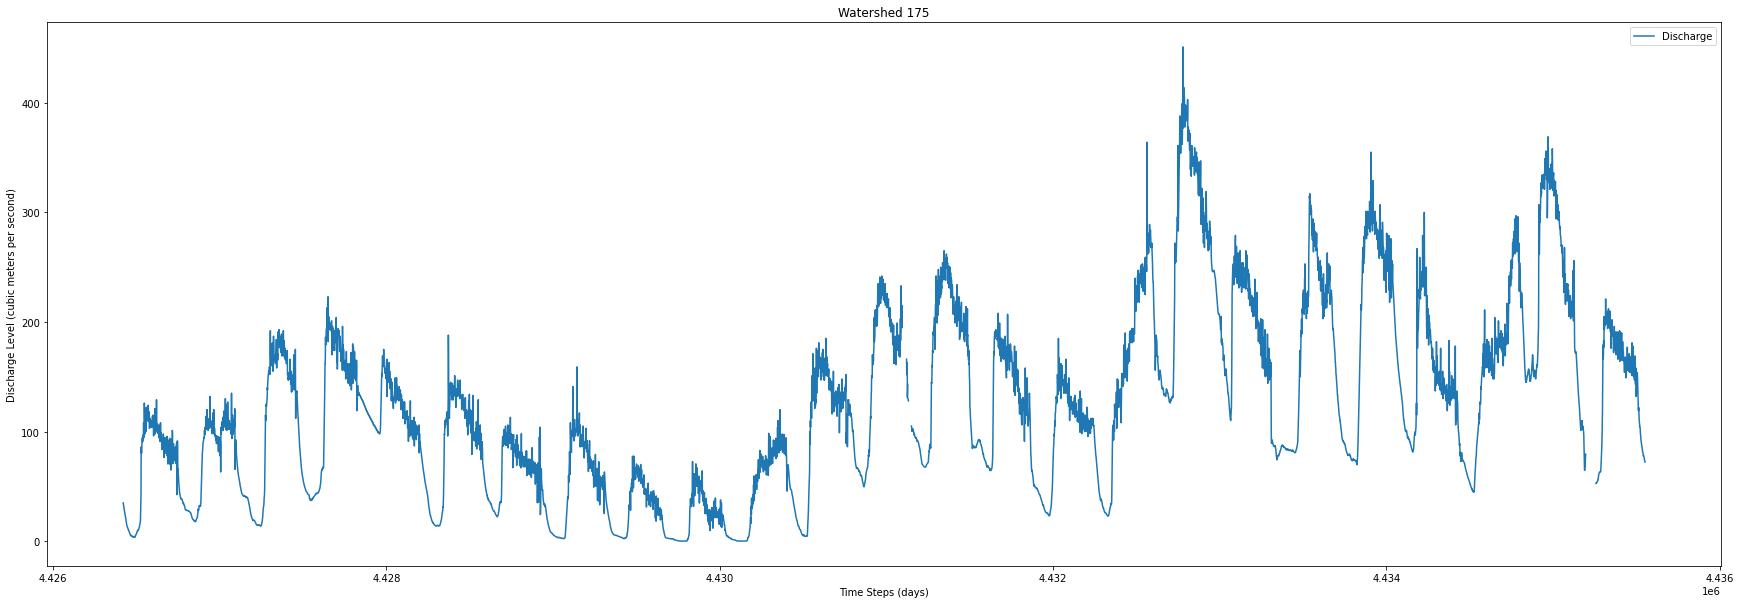

In [69]:
# For visual representation, plotting discharge of watershed 8

x = range(len(shed175))
y = shed175.discharge

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Watershed 175")
plt.xlabel("Time Steps (days forward from January 1, 1994)") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Discharge Level (cubic meters per second)")
plt.plot(y, label = 'Discharge')

plt.legend()
plt.show()

In [78]:
# For this watershed, the missing values do not acrue near peak discharge moments. 
# Using Pandas built in function 'interpolate', nan values will be filled in. 

# Switching the 'time' column to the datetime format.
shed175["time"] = pd.to_datetime(shed175["time"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [79]:
shed175.set_index('time', inplace = True)
for watershedID in set(shed175["watershed"]):
  shed175[shed175["watershed"] == watershedID] = shed175[shed175["watershed"] == watershedID].interpolate(method='time', axis=0, limit_direction="both")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1851: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


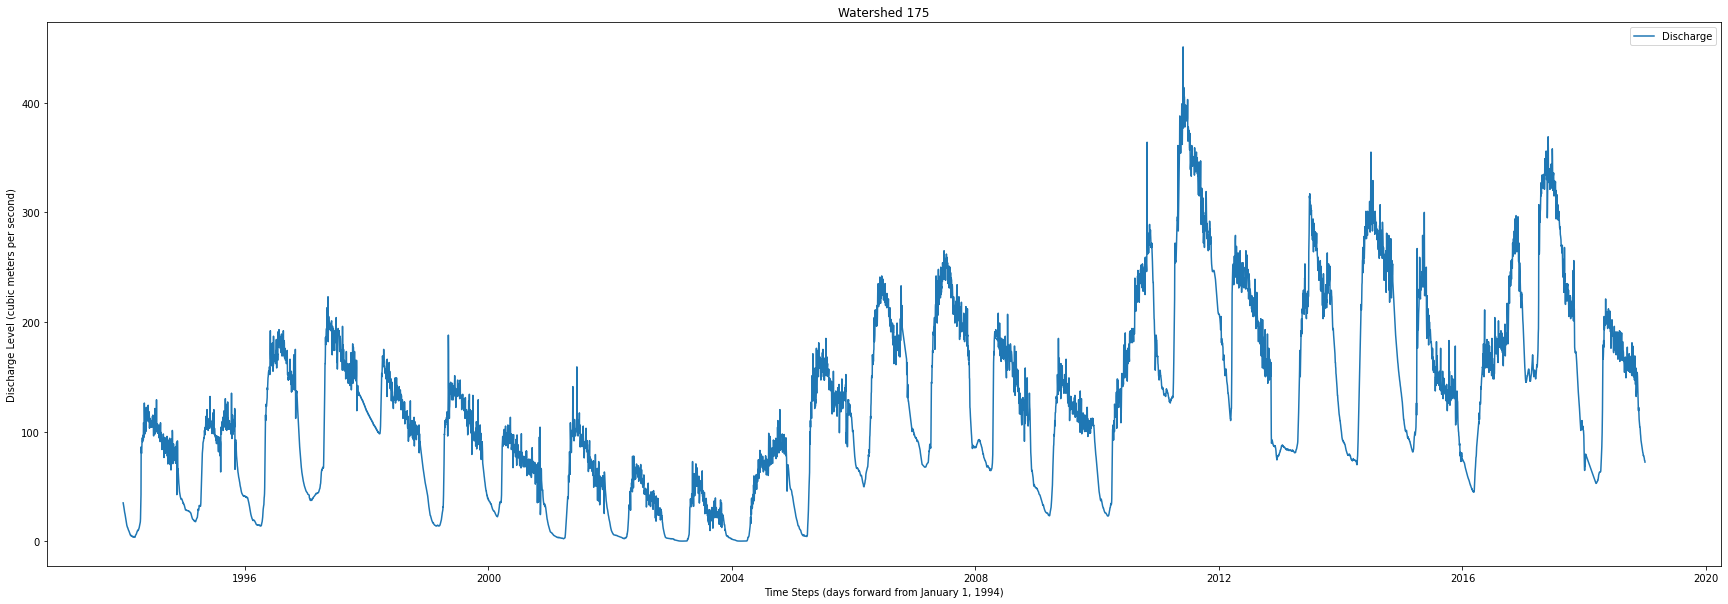

In [80]:
# For visual representation, plotting discharge of watershed 175

x = range(len(shed175))
y = shed175.discharge

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Watershed 175")
plt.xlabel("Time Steps (days forward from January 1, 1994)") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Discharge Level (cubic meters per second)")
plt.plot(y, label = 'Discharge')

plt.legend()
plt.show()

In [115]:
# For purposes of ease of experimentation, a copy will be made of the dataframe. 
model = shed175.copy()

In [116]:
# Herein we will create a function that creates represenations of the past days. 
# And A fortnight is the target variable. --> This can be changed to 10 days out, instead of 14. 

def advance(x):
  num_list = []
  length = len(model.discharge)
  for i in range(length):
    if x + i >= length: # For calculating the target variable
      num = i
    elif i + x < 0: # For calculating the past. 
      num = i
    else:
      num = i + x # Other than the outliers, the value will be discharge[i + 'x']
    forecast = model['discharge'][num]
    num_list.append(forecast)
  name = f"discharge_{x}"    
  model[name] = num_list #model1['discharge'][num]

In [117]:
# The target forecast was identified as 10 days, by a NRCan representative. 
advance(10)
model.head()

,watershed,pr,tasmax,tasmin,discharge,discharge_10
time,,,,,,
1994-01-01,175,0.076526,-22.106535,-28.627773,34.9,25.5
1994-01-02,175,0.224076,-20.438263,-34.967842,33.8,24.8
1994-01-03,175,1.221324,-18.711952,-29.103697,33.1,23.8
1994-01-04,175,0.139639,-26.121840,-35.537575,32.2,23.0
1994-01-05,175,0.120722,-28.488220,-35.271194,31.4,22.1


In [118]:
# Next a column representing the past week's cumulative rainfall. 

def rainfall(x):
  rainfall = []
  length = len(model.discharge)
  for i in range(length):
    # In this case, we're only interested in the past rainfall. 
    if i + x < 0:
      answer = model.pr[:i+1].sum()
    else:
      num = i + x
      answer = model.pr[num:i].sum()
    rainfall.append(answer)
  name = f"pr_{x}"
  model[name] = rainfall
  

In [121]:
rainfall(-7)
model.head()

,watershed,pr,tasmax,tasmin,discharge,discharge_10,pr_-7
time,,,,,,,
1994-01-01,175,0.076526,-22.106535,-28.627773,34.9,25.5,0.076526
1994-01-02,175,0.224076,-20.438263,-34.967842,33.8,24.8,0.300602
1994-01-03,175,1.221324,-18.711952,-29.103697,33.1,23.8,1.521926
1994-01-04,175,0.139639,-26.121840,-35.537575,32.2,23.0,1.661565
1994-01-05,175,0.120722,-28.488220,-35.271194,31.4,22.1,1.782287


In [123]:
# For the purposes of this iteration of the model, only precipitation and discharge values will be kept. 
model = model.drop(['watershed', 'tasmax', 'tasmin'], axis=1)

### Phase Three: Building the Multivariate Time Series Model


In [124]:
time_shift = 10

target_data = model['discharge'].shift(time_shift)
data = model.iloc[:-time_shift]
data

,pr,discharge,discharge_10,pr_-7
time,,,,
1994-01-01,0.076526,34.9,25.5,0.076526
1994-01-02,0.224076,33.8,24.8,0.300602
1994-01-03,1.221324,33.1,23.8,1.521926
1994-01-04,0.139639,32.2,23.0,1.661565
1994-01-05,0.120722,31.4,22.1,1.782287
...,...,...,...,...
2018-12-17,0.000000,80.7,75.4,0.035770
2018-12-18,0.006535,80.7,73.8,0.035770
2018-12-19,0.000000,80.5,73.5,0.042304


In [125]:
test_head = data.index[int(0.75*len(data))]
test_head

Timestamp('2012-09-23 00:00:00')

In [126]:
df_train = data.loc[:test_head,:]
df_test = data.loc[test_head:,:]
target_train = target_data.loc[:test_head]
target_test = target_data.loc[test_head:]

In [127]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [128]:
i = 27
sequence_length = 7
features = ['pr', 'discharge', 'pr_-7']
target = 'discharge_10'

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)

X, y = train_dataset[i]
print(X)

tensor([[ 0.7532, 14.9000,  0.8863],
        [ 0.1776, 14.4000,  1.0122],
        [ 0.0500, 13.9000,  0.9369],
        [ 1.5191, 13.5000,  0.9809],
        [ 0.1561, 12.9000,  2.5000],
        [ 1.5357, 12.4000,  2.6561],
        [ 0.1917, 12.3000,  4.1917]])


In [129]:
from torch.utils.data import DataLoader
torch.manual_seed(42)

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)

X, y = next(iter(train_loader))
print(X.shape)
print(X)

torch.Size([3, 7, 3])
tensor([[[0.0000e+00, 8.3700e+01, 2.5647e+00],
         [2.6122e-01, 7.9000e+01, 2.5453e+00],
         [1.4411e-01, 7.2600e+01, 2.5365e+00],
         [7.7214e-02, 6.4900e+01, 1.8509e+00],
         [4.3465e-01, 7.5400e+01, 1.5384e+00],
         [7.6182e-01, 8.0900e+01, 1.9617e+00],
         [3.6721e+00, 9.0100e+01, 2.7236e+00]],

        [[3.6457e-02, 1.9900e+02, 9.3104e-01],
         [2.7644e+00, 1.9600e+02, 8.0447e-01],
         [8.0622e+00, 2.0000e+02, 3.5689e+00],
         [4.4196e-01, 2.0100e+02, 1.1089e+01],
         [7.9405e+00, 2.0800e+02, 1.1359e+01],
         [3.2225e+00, 2.1800e+02, 1.9297e+01],
         [1.0662e-01, 2.0500e+02, 2.2516e+01]],

        [[3.5942e-02, 3.3600e+01, 6.5263e+00],
         [4.8487e-01, 3.2800e+01, 5.8409e-01],
         [3.4745e+00, 3.2100e+01, 7.0903e-01],
         [1.7309e-01, 3.1500e+01, 4.0799e+00],
         [6.5434e-02, 3.0800e+01, 4.2373e+00],
         [5.7610e-03, 3.0100e+01, 4.3028e+00],
         [2.6406e+00, 3.0100e+01, 

In [130]:
batch_size = 4
sequence_length = 7

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([4, 7, 3])
Target shape: torch.Size([4])


In [131]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [141]:
learning_rate = 5e-4
num_hidden_units = 32

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [142]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(50):
    
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()

Untrained test
--------
Test loss: 35285.86913720446

Epoch 0
---------
Train loss: 14524.035044863514
Test loss: 26561.339191336556

Train loss: 10604.280596834815
Test loss: 20751.328419864647

Epoch 2
---------
Train loss: 7907.642747628347
Test loss: 16221.969211216096

Train loss: 5922.535291055571
Test loss: 12667.724175883806

Epoch 4
---------
Train loss: 4483.326339805426
Test loss: 9909.468122679382

Train loss: 3434.6026954802765
Test loss: 7708.450750553827

Epoch 6
---------
Train loss: 2672.1790920368485
Test loss: 6021.834267546959

Train loss: 2106.4362963385083
Test loss: 4709.320598391304

Epoch 8
---------
Train loss: 1706.515134351808
Test loss: 3766.1159581185534

Train loss: 1394.971774750982
Test loss: 3017.3662710167114

Epoch 10
---------
Train loss: 1169.300252578051
Test loss: 2485.2242863014367

Train loss: 997.6518280686237
Test loss: 2014.4319613303487

Epoch 12
---------
Train loss: 870.3027906479158
Test loss: 1693.3360363824354

Train loss: 769.74622015

In [143]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

# for c in df_out.columns:
#     df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


            discharge_10  Model forecast
time                                    
1994-01-01          25.5       47.214214
1994-01-02          24.8       43.668999
1994-01-03          23.8       39.744217
1994-01-04          23.0       36.350029
1994-01-05          22.1       36.016941
...                  ...             ...
2018-12-17          75.4       71.899681
2018-12-18          73.8       72.784065
2018-12-19          73.5       73.443039
2018-12-20          73.4       71.963013
2018-12-21          72.1       69.525993

[9122 rows x 2 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


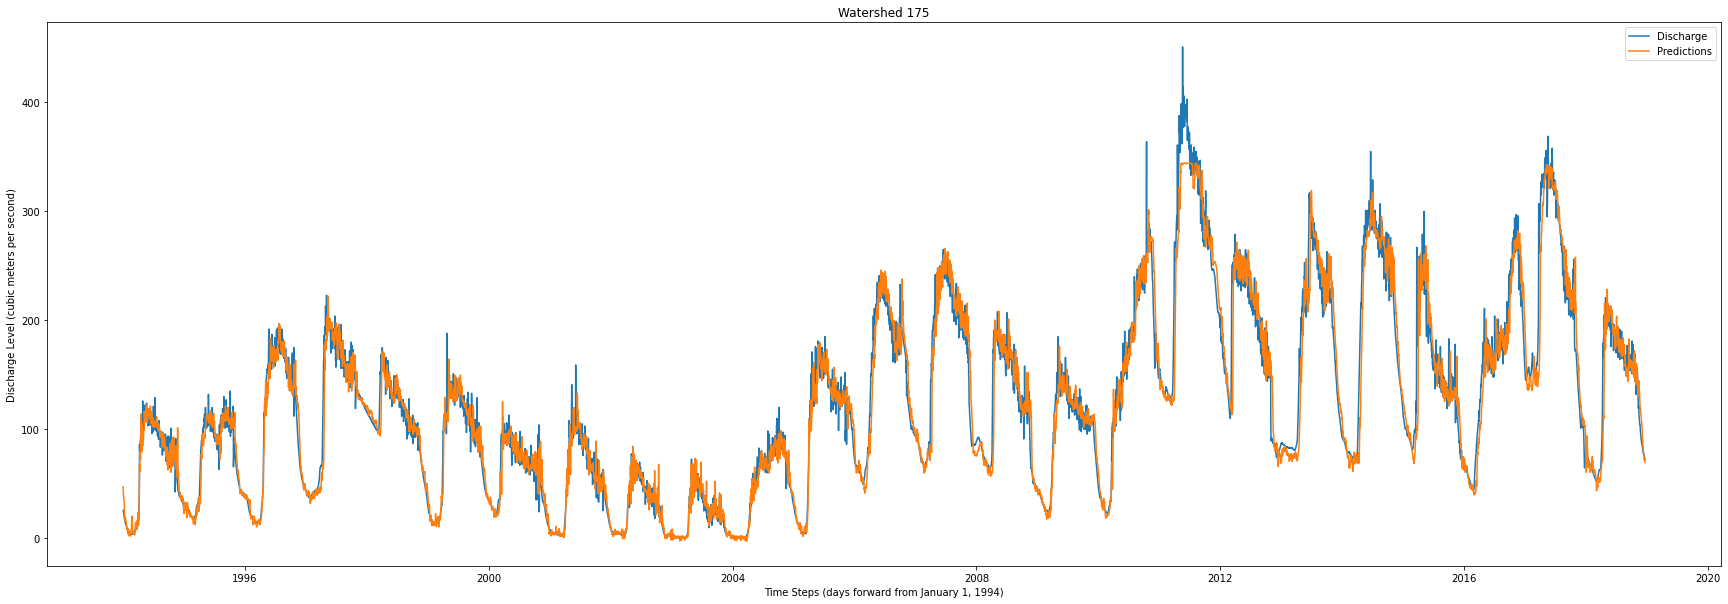

In [144]:
# For visual representation, plotting discharge of watershed 8

x = range(len(shed175))
y1 = df_out.discharge_10
y2 = df_out['Model forecast']

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Watershed 175")
plt.xlabel("Time Steps (days forward from January 1, 1994)") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Discharge Level (cubic meters per second)")
plt.plot(y1, label = 'Discharge')
plt.plot(y2, label = 'Predictions')

plt.legend()
plt.show()

In [145]:
# We are using SMAPE to measure the performance of our models. 
total = 0
for i in range(len(df_out)):
  predict = df_out['Model forecast'][i]
  recorded = df_out.discharge_10[i]
  top = np.abs(predict - recorded)
  bottom = ((predict + recorded)/2)
  answer = top/bottom
  total += answer
smape = total/len(df_out) * 100
print("For Watershed 175, this model's sMAPE score is:", smape)

For Watershed 175, this model's sMAPE score is: 16.545325084985755


In [105]:
# Plotting the loss scores, both training and test. 

x = range(len(shed175))
y1 = df_out.discharge_10
y2 = df_out['Model forecast']

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Watershed 175")
plt.xlabel("Time Steps (days forward from January 1, 1994)") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Discharge Level (cubic meters per second)")
plt.plot(y1, label = 'Discharge')
plt.plot(y2, label = 'Predictions')

plt.legend()
plt.show()